In [49]:
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [50]:
df = pd.read_csv('data/train_bikes.csv')

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Вспомогательные функции

In [251]:
def draw_graphics(alpha, train_scores, valid_scores):
    """
    по оси x отложены значения alpha
    по оси y отложены средние значения меры качества
    """
    fig, ax = plt.subplots(figsize=(10,10))
    fig.subplots_adjust(left=0.08, right=0.98, wspace=0.3)
    ax.set_xscale('symlog', linthreshy=0.00001)
    ax.plot(alpha_range, train_scores, 'ro', label="train metrics") 
    ax.plot(alpha_range, valid_scores, label="valid metrics")
    plt.legend(loc=2, borderaxespad=0.)
    ax.grid(True)
    plt.show()

## Предобработка данных:

In [52]:
def get_supervised_array(df_origin):
    """
    Получаем список строк для разделения исходной матрицы на train и test.
    """
    df = df_origin.copy()
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M')
    df['year'] = df.loc[:, 'datetime'].dt.year
    df['month'] = df.loc[:, 'datetime'].dt.month
    df['hour'] = df.loc[:, 'datetime'].dt.hour
    stroka = df.to_string(
        columns=['year','month','hour'], 
        col_space=0,
        header=False,
        index=False,
    )
    return np.array(re.sub(' +','-',stroka).split('\n'))

In [53]:
def get_date_features(df_origin):
    """
    Разбиваем datetime на части.
    """
    df = df_origin.copy()
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M')
    df['year'] = df.loc[:, 'datetime'].dt.year
    df['month'] = df.loc[:, 'datetime'].dt.month
    df['day'] = df.loc[:, 'datetime'].dt.day
    df['hour'] = df.loc[:, 'datetime'].dt.hour
    df['weekday'] = df.loc[:, 'datetime'].dt.weekday
    
    return df

In [54]:
def class_hour(df):
    """
    Создаём интервалы времени
    """
    df_tmp = df.copy()
    df_tmp['class_hour'] = df_tmp['hour'].map(
    lambda x:
        "night" if x == 23 or x <= 4 else 
        "morning" if x <= 8 and x > 4 else
        "rush_morning" if x <= 9 and x > 8 else
        "day" if x <= 16 and x > 9 else
        "rush_day" if x <= 19 and x > 16 else
        "evening" 

    )
    return df_tmp

In [104]:
def mapping(df):
    """
    Превращаем категореальные призанки в ветокра в вида {0,1, C-1} где C - количество уникальных значений.
    
    """
    
    df_tmp = df.copy()
    df_tmp['weather'] = df_tmp['weather'].replace(
        df_tmp['weather'].value_counts().to_dict()
    )
    df_tmp['year'] = df_tmp['year'].replace(
        df_tmp['year'].value_counts().to_dict()
    )
    df_tmp['month'] = df_tmp['month'].replace(
        df_tmp['month'].value_counts().to_dict()
    )
    df_tmp['weekday'] = df_tmp['weekday'].replace(
        df_tmp['weekday'].value_counts().to_dict()
    )
    df_tmp['class_hour'] = df_tmp['class_hour'].replace(
        df_tmp['class_hour'].value_counts().to_dict()
    )

    return df_tmp
    

In [106]:
def prepare_features(df, drop_cols=[], target_feature=''):
    """
    Функция подготовки фич. Здесь агрегируеться все преобразования над исходным DataFrame.
    """
    df_tmp = df.copy()
    targets = ["casual", "registered", "count"]
# оставляем только один из целевых признаков (casual, registred или count)
    if target_feature in targets:
        y_target = df_tmp[target_feature]
        drop_cols.extend(targets)
# выделяем признаки для "времени дня", "месяца" и дня недели      
    df_clean = get_date_features(df)
# создаём новую переменную (утро, день, вечер, ночь).
    df_clean = class_hour(df_clean)
# Преобразовывала бинарные признаки в вектора с {0,1} а категориальные признаки в вектора с {0,1,...,C-1}
    df_clean = mapping(df_clean)
# Удаляем ненужные признаки (сильно скоррелированные и просто бесполковые, типа datetime, day)
    df_clean = df_clean.drop(drop_cols, axis=1)
    df_clean.head()
    
    return df_clean, y_target

# Getting hands dirty

In [107]:
y_label = 'count'
drop_cols = [
    "day",
    "season",
    "atemp",
    "humidity",
    "datetime",
    "hour",
]
year_month_hour = get_supervised_array(df)
year_month_hour[:5]    

array(['2011-1-0', '2011-1-1', '2011-1-2', '2011-1-3', '2011-1-4'],
      dtype='<U10')

In [108]:
df_train, y_target = prepare_features(df, drop_cols,y_label)
df_train.head()

,holiday,workingday,weather,temp,windspeed,year,month,weekday,class_hour
0,0,0,7192,9.84,0.0,5422,884,1584,2688
1,0,0,7192,9.02,0.0,5422,884,1584,2688
2,0,0,7192,9.02,0.0,5422,884,1584,2688
3,0,0,7192,9.84,0.0,5422,884,1584,2688
4,0,0,7192,9.84,0.0,5422,884,1584,2688


In [109]:
y_target.head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

## Baseline modelling

In [110]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold

In [111]:
# alpha - это общая сила регуляризации
# l1_ration - доля, которая приходтися на Lasso регуляризацию. Соответственно остальное идет на Rigde
regressor = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [112]:
# преобразовываем признаки в вектора
onehotencoder = OneHotEncoder(categorical_features=[2,5,6,7,8])

In [113]:
# нормализовываем признаки
standart = StandardScaler(with_mean=False)

In [114]:
# строим модель
model = make_pipeline(
    onehotencoder, 
    standart, 
    regressor)

In [154]:
def rlmse_score(y_test, y_hat):
    """
    Считаем rlmse ошибку
    """
    # Your code here
    # в y_hat есть отрицательыне значения. Зануляю.
    # Интерсно какой они несут смысл и почему они получаеются.
    y_hat = list(map(lambda x : x if x >=0 else 0, y_hat.tolist())) 
    if len(y_hat) != len(y_test):
        print("Error!")
        return -1
    N = len(y_hat)
    summ = 0
    for idx in range(0, N):
        summ += (np.log10(y_test[idx] + 1) - np.log10(y_hat[idx] + 1))**2
    rlmse = np.sqrt(summ/N)
    return rlmse

# Эту функцию трогать не надо
def rlmse_scorer(estimator, X, y):
    y_hat = estimator.predict(X)
    
    return rlmse_score(y, y_hat)

In [155]:
# rlmse_score(
#     y_test=[0.75, 0.86, -0.1],
#     y_hat=[0.70, 0.81, -0.4]
# )

In [171]:
from sklearn.model_selection import validation_curve

In [187]:
# Это не обычная кросс-валидация а стратифицированная. №
# С ее помощью мы добъемся того, что в обучающем и валидационном фолде будет одна и та же пропорция годов-месяцев-часов
# Тут то и понадобится нам year_month_hour
# Подробности http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123)

# Переберем 20 значений в интервале от 10^-3 до 10^5
# Чутка увеличел aplha. 
alpha_range = np.logspace(-1, 10, 30)

param_name = "elasticnet__alpha"
# пишем не просто alpha, потому что у нас pipeline и sklearn должен как-то понимать параметр какого этапа мы перебираем
# cv=cv.split(df_clean, year_month_hour)
# model.fit(df_clean, y_target)
# regressor.get_params().keys()
y = y_target.as_matrix()
train_scores, valid_scores = validation_curve(model, df_train, y, param_name=param_name, param_range=alpha_range,
                                               cv=cv.split(df_clean, year_month_hour), scoring=rlmse_scorer)

# На выходе мы получим 2 матрицы размера 20 на n_folds
# Потому что у нас было 5 фолдов и 20 возможных значений гиперпараметра
# А матриц 2, потому что в каждом фолде есть обучающая и валидационная часть

In [188]:
train_scores

array([[0.53445837, 0.53301667, 0.53145205, 0.5377961 , 0.53425208],
       [0.52674973, 0.52544489, 0.5231944 , 0.52931101, 0.52492334],
       [0.51868716, 0.51797668, 0.5136925 , 0.51849039, 0.51836864],
       [0.52177331, 0.52339945, 0.52311953, 0.52411584, 0.52338386],
       [0.57129727, 0.57358525, 0.57335253, 0.57413551, 0.57093133],
       [0.62498254, 0.62767671, 0.62676472, 0.6282817 , 0.62523225],
       [0.6564053 , 0.65922567, 0.65800543, 0.65979422, 0.65707946],
       [0.67228447, 0.67516111, 0.67371534, 0.67563428, 0.67321824],
       [0.67864078, 0.68157935, 0.68003396, 0.68203473, 0.67961511],
       [0.67974334, 0.6827429 , 0.68111333, 0.68316628, 0.68072907],
       [0.67974334, 0.6827429 , 0.68111333, 0.68316628, 0.68072907],
       [0.67974334, 0.6827429 , 0.68111333, 0.68316628, 0.68072907],
       [0.67974334, 0.6827429 , 0.68111333, 0.68316628, 0.68072907],
       [0.67974334, 0.6827429 , 0.68111333, 0.68316628, 0.68072907],
       [0.67974334, 0.6827429 , 0.

In [189]:
valid_scores

array([[0.52868775, 0.54213677, 0.53654747, 0.52852005, 0.53701222],
       [0.51922465, 0.52913341, 0.52822459, 0.51981785, 0.53364158],
       [0.51000367, 0.5169914 , 0.52404258, 0.51687884, 0.51972054],
       [0.52415534, 0.52521014, 0.51960149, 0.51891188, 0.52949243],
       [0.5748344 , 0.57232938, 0.56972171, 0.56862315, 0.58155823],
       [0.62959409, 0.62795432, 0.6237468 , 0.62180364, 0.63171802],
       [0.66154037, 0.66028715, 0.65527928, 0.65306126, 0.66148438],
       [0.67766121, 0.67647468, 0.67116986, 0.66875573, 0.67665544],
       [0.68410052, 0.68286896, 0.67755441, 0.67502319, 0.68303449],
       [0.6852085 , 0.68401454, 0.67865153, 0.67613449, 0.68416093],
       [0.6852085 , 0.68401454, 0.67865153, 0.67613449, 0.68416093],
       [0.6852085 , 0.68401454, 0.67865153, 0.67613449, 0.68416093],
       [0.6852085 , 0.68401454, 0.67865153, 0.67613449, 0.68416093],
       [0.6852085 , 0.68401454, 0.67865153, 0.67613449, 0.68416093],
       [0.6852085 , 0.68401454, 0.

In [190]:
# стандартное отклонение
np.std(train_scores, axis=1)

array([0.00209536, 0.00204134, 0.00188959, 0.00076754, 0.00129292,
       0.00130389, 0.00126964, 0.00123727, 0.00125748, 0.00127679,
       0.00127679, 0.00127679, 0.00127679, 0.00127679, 0.00127679,
       0.00127679, 0.00127679, 0.00127679, 0.00127679, 0.00127679,
       0.00127679, 0.00127679, 0.00127679, 0.00127679, 0.00127679,
       0.00127679, 0.00127679, 0.00127679, 0.00127679, 0.00127679])

In [191]:
# стандартное отклонение
np.std(valid_scores, axis=1)

array([0.0052599 , 0.00560865, 0.00457322, 0.00388611, 0.00460668,
       0.00367365, 0.00349724, 0.00352106, 0.00356847, 0.00357685,
       0.00357685, 0.00357685, 0.00357685, 0.00357685, 0.00357685,
       0.00357685, 0.00357685, 0.00357685, 0.00357685, 0.00357685,
       0.00357685, 0.00357685, 0.00357685, 0.00357685, 0.00357685,
       0.00357685, 0.00357685, 0.00357685, 0.00357685, 0.00357685])

In [253]:
# среднее значение 
mean_scores_train = np.mean(train_scores, axis=1)

In [254]:
# среднее значение 
mean_scores_valid = np.mean(valid_scores, axis=1)

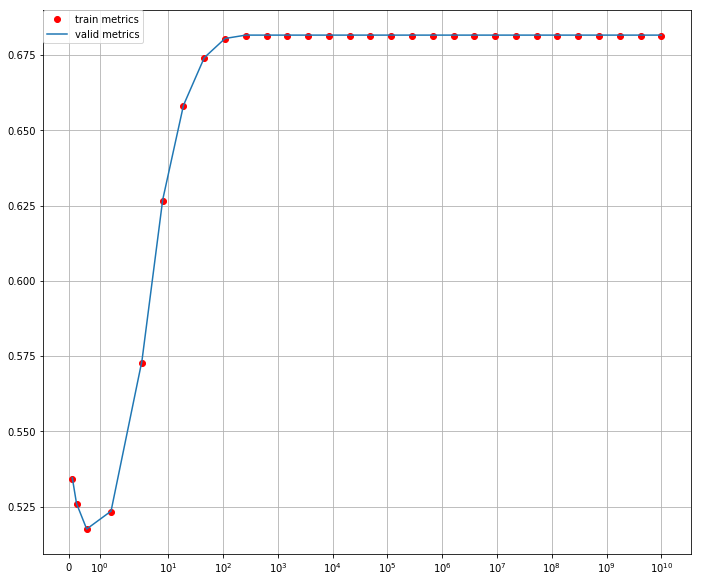

In [252]:
draw_graphics(alpha_range, mean_scores_train, mean_scores_valid)